In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap, shiftgrid, addcyclic
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy import stats
import nc_time_axis
from xclim import ensembles
import cmocean
import cartopy.crs as ccrs
from scipy.stats import ks_2samp
import cftime
from matplotlib.colors import TwoSlopeNorm
import matplotlib.dates as mdates
from dask.distributed import Client
from matplotlib.ticker import FormatStrFormatter
import re
from itertools import groupby

In [2]:
client = Client()
client

/home/brunol/miniconda3/envs/HTHH_Bruno/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38655 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:34733' processes=8 threads=56, memory=755.75 GiB>

2025-02-06 15:19:13,884 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:41535' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'original-open_dataset-TS-0da64ed2561b840785648e7495e938b2', 'original-open_dataset-TS-189d3b45fa1ce2cdd29f1f144240b91a', 'original-open_dataset-TS-b61c83f23e91769f8cb8d6cea965b3ee'} (stimulus_id='handle-worker-cleanup-1738851553.8842337')
2025-02-06 15:19:13,910 - distributed.nanny - WARNING - Restarting worker
2025-02-06 15:19:16,263 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:46669' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'original-open_dataset-TS-79b687ec888ede291baf62a5bddbeefa', 'original-open_dataset-TS-c24e6a039a4132c3b299308550741452'} (stimulus_id='handle-worker-cleanup-1738851556.263461')
2025-02-06 15:19:16,284 - distributed.nanny - WARNING - Restarting worker
2025-02-06 15:20:03,979 - distributed.scheduler - WARN

In [3]:
# define function for sat processing

def process_sat(ds):
    ds = ds.drop_vars(["time_bnds", "gw"], errors="ignore").sortby('lat')   
    #ds = ds[['TREFHT']]
    ds['time'] = pd.date_range("2022-02-01", freq='1ME', periods=ds.time.shape[0])
    ds['ens'] = np.arange(1,ds.ens.shape[0]+1)
    
    #ds = ds.rename({'tas': 'sat'})
    # Rename variable if it exists
    var_names = ["tas", "T2", "TREFHT", "ts", "TS"]
    for var in var_names:
        if var in ds.data_vars:
            ds = ds.rename({var: 'sat'})
            ds['sat'].attrs['units'] = 'K'
            break  # Exit the loop after renaming the first matching variable
    ds['sat'].attrs['units'] = 'K'

    return ds

In [4]:
# set default fontsize for Plots
plt.rcParams.update({"font.size": 22})
xr.set_options(keep_attrs=True)

In [5]:
### Load CMAM
#select model name
model = "CMAM"
#chose infilepath
infile_path = Path(f"/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1_fixedSST/{model}")

#select target variable 
what = "tas"
#select infiles with and without HTHH
infiles_w = sorted(infile_path.glob(f"{what}*H2Oonly*.nc"))
infiles_wo = sorted(infile_path.glob(f"{what}*NoVolc*.nc"))

#Open datasets for with and without
cmam_w = xr.open_mfdataset(
    infiles_w[:],
    parallel=True,
    combine="nested",
    concat_dim=["ens"]).pipe(process_sat)

cmam_wo = xr.open_mfdataset(
    infiles_wo[:],
    parallel=True,
    combine="nested",
    concat_dim=["ens"]).pipe(process_sat)



Exception ignored in: <function CachingFileManager.__del__ at 0x7fc61f0e7f60>
Traceback (most recent call last):
  File "/home/brunol/miniconda3/envs/HTHH_Bruno/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/home/brunol/miniconda3/envs/HTHH_Bruno/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2624, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2587, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2028, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID


In [6]:
### Load WACCM fixed SST
#select model name
model = "waccm6mam"
infile_path = Path(f"/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1_fixedSST/{model}")

# select variable name
what = "ts"
infiles_w = sorted(infile_path.glob(f"*SO2andH2O*{what}.nc"))
infiles_wo = sorted(infile_path.glob(f"*NoVolc*{what}.nc"))

# load datasets with and without HTHH
waccm_w = xr.open_mfdataset(
    infiles_w[:],
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"]).pipe(process_sat)

waccm_wo = xr.open_mfdataset(
    infiles_wo[:],
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"]).pipe(process_sat)

In [7]:
### Load GEOSCCM
#select model name
path = "/home/brunol/HTHH/GEOS"


# load datasets with and without HTHH
geos_wo = xr.open_dataset(f"{path}/geos_wo_sat.nc")
geos_w = xr.open_dataset(f"{path}/geos_w_sat.nc")

In [8]:
geos_w

<xarray.Dataset> Size: 310MB
Dimensions:  (lon: 360, lat: 181, time: 119, ens: 10)
Coordinates:
  * lon      (lon) float64 3kB -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * time     (time) datetime64[ns] 952B 2022-02-28 2022-03-31 ... 2031-12-31
  * ens      (ens) int64 80B 1 2 3 4 5 6 7 8 9 10
Data variables:
    sat      (ens, time, lat, lon) float32 310MB ...

In [9]:
# LOAD MIROC

model = "MIROC-CHASER"
infile_path = Path(f"/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1_fixedSST/{model}")

infiles_wo = sorted(infile_path.glob('*tas_*NoVolc*.ensemble*.nc'))
infiles_w = sorted(infile_path.glob('*tas_*SO2andH2O*.ensemble*.nc'))


# Open and concatenate NetCDF files along 'ens' dimension
miroc_w = xr.concat(
    [xr.open_mfdataset(list(files), combine="by_coords", parallel=False) for _, files in groupby(infiles_w, key=lambda f: re.search(r'ensemble(\d+)', str(f)).group(1))],
    dim="ens"
).pipe(process_sat)

miroc_wo = xr.concat(
    [xr.open_mfdataset(list(files), combine="by_coords", parallel=False) for _, files in groupby(infiles_wo, key=lambda f: re.search(r'ensemble(\d+)', str(f)).group(1))],
    dim="ens"
).pipe(process_sat)

In [10]:
infile_path = Path(f"/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1and4_coupledocean/waccm6mam-45plevels")

what = "tas"
infiles_w = sorted(infile_path.glob(f"*SO2andH2O*{what}.nc"))
infiles_wo = sorted(infile_path.glob(f"*NoVolc*{what}.nc"))


waccm2_wo = xr.open_mfdataset(
    infiles_wo[:],
    parallel=False,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
).pipe(process_sat)

waccm2_w = xr.open_mfdataset(
    infiles_w[:],
    parallel=False,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
).pipe(process_sat)

In [11]:
cmam_w_zm = cmam_w.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon").mean("ens")
cmam_wo_zm = cmam_wo.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon").mean("ens")
cmam_diff = cmam_w_zm - cmam_wo_zm

waccm_w_zm = waccm_w.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon").mean("ens")
waccm_wo_zm = waccm_wo.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon").mean("ens")
waccm_diff = waccm_w_zm - waccm_wo_zm

miroc_w_zm = miroc_w.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon").mean("ens")
miroc_wo_zm = miroc_wo.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon").mean("ens")
miroc_diff = miroc_w_zm - miroc_wo_zm

geos_w_zm = geos_w.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon").mean("ens")
geos_wo_zm = geos_wo.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon").mean("ens")
geos_diff = geos_w_zm - geos_wo_zm


waccm2_w_zm = waccm2_w.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon").mean("ens")
waccm2_wo_zm = waccm2_wo.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon").mean("ens")
waccm2_diff = waccm2_w_zm - waccm2_wo_zm

diffs = {"CMAM": cmam_diff, "MIROC-CHASER": miroc_diff, "GEOSCCM": geos_diff, "WACCM fixed SST": waccm_diff, "WACCM coupled ocean": waccm2_diff}


In [12]:
cmam_w_zm = cmam_w.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon")
cmam_wo_zm = cmam_wo.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon")

waccm_w_zm = waccm_w.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon")
waccm_wo_zm = waccm_wo.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon")


miroc_w_zm = miroc_w.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon")
miroc_wo_zm = miroc_wo.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon")

geos_w_zm = geos_w.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon")
geos_wo_zm = geos_wo.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon")



waccm2_w_zm = waccm2_w.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon")
waccm2_wo_zm = waccm2_wo.sat.resample(time = "1YE").mean().sel(time = slice("2022", "2031")).mean("lon")



In [13]:
# using equal_var = False because there are only 9 ens without pert and 10 with pert
_, cmam_pv = stats.ttest_ind(cmam_w_zm.values, cmam_wo_zm.values, axis = 0, equal_var = False)

_, miroc_pv = stats.ttest_ind(miroc_w_zm.values, miroc_wo_zm.values, axis = 0, equal_var = False)

_, waccm_pv = stats.ttest_ind(waccm_w_zm.values, waccm_wo_zm.values, axis = 0, equal_var = False)

_, waccm2_pv = stats.ttest_ind(waccm2_w_zm.values, waccm2_wo_zm.values, axis = 0, equal_var = False)

_, geos_pv = stats.ttest_ind(geos_w_zm.values, geos_wo_zm.values, axis = 0, equal_var = False)

pv_das = [cmam_pv, miroc_pv, geos_pv, waccm_pv, waccm2_pv]

In [14]:
vmin = min([miroc_diff.min(), cmam_diff.min(), geos_diff.min(), waccm_diff.min(), waccm2_diff.min()]).values
vmax = max([miroc_diff.max(), cmam_diff.max(), geos_diff.max(), waccm_diff.max(), waccm2_diff.max()]).values

if abs(vmin) < abs(vmax):
    vmin = -vmax
else:
    vmax = abs(vmin)

divnorm = TwoSlopeNorm(vmin= vmin, vcenter=0, vmax= vmax)

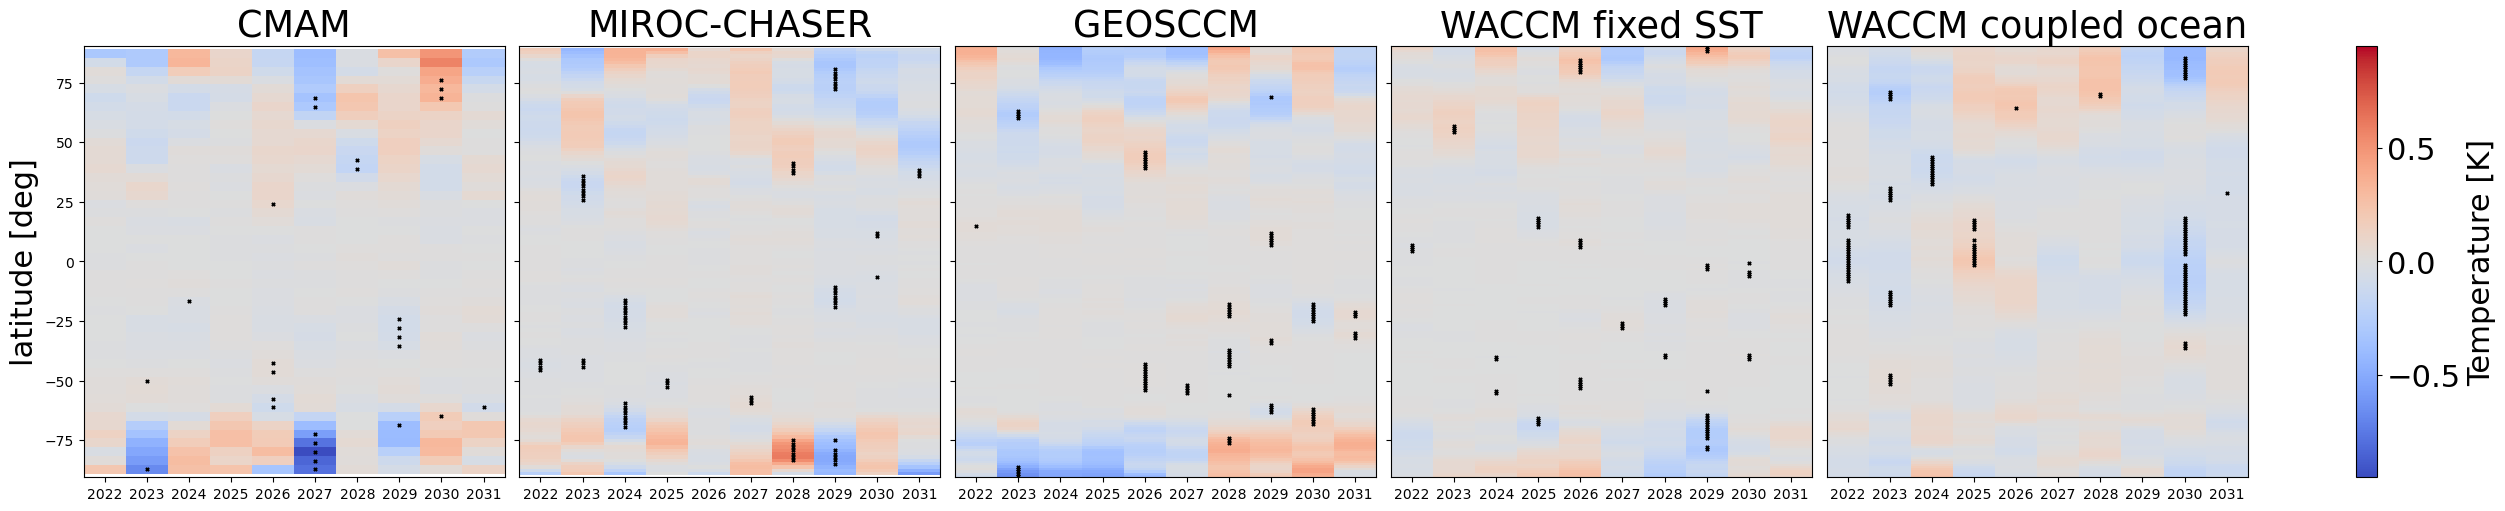

In [15]:
# create list with every second year
xticks = list(cmam_w_zm["time"].values)


# create Subplot 1x5 grid, 
fig, axs = plt.subplots(1, 5, figsize=(25, 5), constrained_layout = True, sharex = True, sharey = True)
axs = axs.flatten()

# Loop over each season and corresponding axis
for ax, model, pv in zip(axs, diffs, pv_das):
    sig_time, sig_lat = np.where(pv <= 0.05)
    # Extract the data for each model
    data = diffs[model]
    
    # Create the pcolormesh plot
    plot = ax.pcolormesh(
        data["time"],
        data["lat"],
        data.values.T,
        cmap="coolwarm",
        norm = divnorm,
    )
    ax.scatter(
        data["time"][sig_time],
        data["lat"][sig_lat],
        color="black",
        marker="x",
        s = 5
    )
    
    # set title and costumize xticks
    ax.set_title(f"{model}")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xticks(xticks)               

    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    
# Add one colorbar
fig.colorbar(plot, ax=axs, orientation="vertical", fraction=0.05, pad=0.05, label="Temperature [K]")
axs[0,].set_ylabel("latitude [deg]")

plt.savefig(fname = "annual_temp_zm")
plt.show()
plt.close(fig)

In [16]:
sel_dict = dict(time = slice('2022-01','2031-12'))

weights_cmam = np.cos(np.deg2rad(cmam_w.sat.lat))
weights_cmam.name = "weights"
cmam_w_gm = cmam_w.sat.sel(**sel_dict).weighted(weights_cmam).mean(['lat','lon']).load()
cmam_wo_gm = cmam_wo.sat.sel(**sel_dict).weighted(weights_cmam).mean(['lat','lon']).load()

weights_miroc = np.cos(np.deg2rad(miroc_w.sat.lat))
weights_miroc.name = "weights"
miroc_w_gm = miroc_w.sat.sel(**sel_dict).weighted(weights_miroc).mean(['lat','lon']).load()
miroc_wo_gm = miroc_wo.sat.sel(**sel_dict).weighted(weights_miroc).mean(['lat','lon']).load()

weights_waccm = np.cos(np.deg2rad(waccm_w.sat.lat))
weights_waccm.name = "weights"
waccm_w_gm = waccm_w.sat.sel(**sel_dict).weighted(weights_waccm).mean(['lat','lon']).load()
waccm_wo_gm = waccm_wo.sat.sel(**sel_dict).weighted(weights_waccm).mean(['lat','lon']).load()


weights_geos = np.cos(np.deg2rad(geos_w.sat.lat))
weights_geos.name = "weights"
geos_w_gm = geos_w.sat.sel(**sel_dict).weighted(weights_geos).mean(['lat','lon']).load()
geos_wo_gm = geos_wo.sat.sel(**sel_dict).weighted(weights_geos).mean(['lat','lon']).load()

weights_waccm2 = np.cos(np.deg2rad(waccm2_w.sat.lat))
weights_waccm2.name = "weights"
waccm2_w_gm = waccm2_w.sat.sel(**sel_dict).weighted(weights_waccm2).mean(['lat','lon']).load()
waccm2_wo_gm = waccm2_wo.sat.sel(**sel_dict).weighted(weights_waccm2).mean(['lat','lon']).load()


In [17]:
cmam_w_gm_an = cmam_w_gm.resample(time = "1YE").mean()
cmam_wo_gm_an = cmam_wo_gm.resample(time = "1YE").mean()
cmam_anom_gm_an = cmam_w_gm_an - cmam_wo_gm_an

miroc_w_gm_an = miroc_w_gm.resample(time = "1YE").mean()
miroc_wo_gm_an = miroc_wo_gm.resample(time = "1YE").mean()
miroc_anom_gm_an = miroc_w_gm_an - miroc_wo_gm_an

waccm_w_gm_an = waccm_w_gm.resample(time = "1YE").mean()
waccm_wo_gm_an = waccm_wo_gm.resample(time = "1YE").mean()
waccm_anom_gm_an = waccm_w_gm_an - waccm_wo_gm_an

geos_w_gm_an = geos_w_gm.resample(time = "1YE").mean()
geos_wo_gm_an = geos_wo_gm.resample(time = "1YE").mean()
geos_anom_gm_an = geos_w_gm_an - geos_wo_gm_an

waccm2_w_gm_an = waccm2_w_gm.resample(time = "1YE").mean()
waccm2_wo_gm_an = waccm2_wo_gm.resample(time = "1YE").mean()
waccm2_anom_gm_an = waccm2_w_gm_an - waccm2_wo_gm_an



In [18]:
#create dataframe with annual sat for each ensemble with and without HTHH
#MIROC
df_cmam =  cmam_w_gm_an.to_dataframe().reset_index()
df_cmam['time'] = df_cmam.time.dt.strftime('%Y')
df_cmam['what'] = df_cmam.shape[0]*['with']
df_cmam_wo =  cmam_wo_gm_an.to_dataframe().reset_index()
df_cmam_wo['what'] = df_cmam_wo.shape[0]*['without']
df_cmam_wo['time'] = df_cmam_wo.time.dt.strftime('%Y')

df_cmam_anom =  cmam_anom_gm_an.to_dataframe().reset_index()
df_cmam_anom['what'] = df_cmam_anom.shape[0]*['anom']
df_cmam_anom['time'] = df_cmam_anom.time.dt.strftime('%Y')
df_cmam_all = pd.concat([df_cmam, df_cmam_wo, df_cmam_anom])

df_miroc =  miroc_w_gm_an.to_dataframe().reset_index()
df_miroc['time'] = df_miroc.time.dt.strftime('%Y')
df_miroc['what'] = df_miroc.shape[0]*['with']
df_miroc_wo =  miroc_wo_gm_an.to_dataframe().reset_index()
df_miroc_wo['what'] = df_miroc_wo.shape[0]*['without']
df_miroc_wo['time'] = df_miroc_wo.time.dt.strftime('%Y')
df_miroc_anom =  miroc_anom_gm_an.to_dataframe().reset_index()
df_miroc_anom['what'] = df_miroc_anom.shape[0]*['anom']
df_miroc_anom['time'] = df_miroc_anom.time.dt.strftime('%Y')
df_miroc_all = pd.concat([df_miroc, df_miroc_wo, df_miroc_anom])


df_geos =  geos_w_gm_an.to_dataframe().reset_index()
df_geos['time'] = df_geos.time.dt.strftime('%Y')
df_geos['what'] = df_geos.shape[0]*['with']
df_geos_wo =  geos_wo_gm_an.to_dataframe().reset_index()
df_geos_wo['what'] = df_geos_wo.shape[0]*['without']
df_geos_wo['time'] = df_geos_wo.time.dt.strftime('%Y')
df_geos_anom =  geos_anom_gm_an.to_dataframe().reset_index()
df_geos_anom['what'] = df_geos_anom.shape[0]*['anom']
df_geos_anom['time'] = df_geos_anom.time.dt.strftime('%Y')
df_geos_all = pd.concat([df_geos, df_geos_wo, df_geos_anom])

df_waccm =  waccm_w_gm_an.to_dataframe().reset_index()
df_waccm['time'] = df_waccm.time.dt.strftime('%Y')
df_waccm['what'] = df_waccm.shape[0]*['with']
df_waccm_wo =  waccm_wo_gm_an.to_dataframe().reset_index()
df_waccm_wo['what'] = df_waccm_wo.shape[0]*['without']
df_waccm_wo['time'] = df_waccm_wo.time.dt.strftime('%Y')
df_waccm_anom =  waccm_anom_gm_an.to_dataframe().reset_index()
df_waccm_anom['what'] = df_waccm_anom.shape[0]*['anom']
df_waccm_anom['time'] = df_waccm_anom.time.dt.strftime('%Y')
df_waccm_all = pd.concat([df_waccm, df_waccm_wo, df_waccm_anom])


df_waccm2 =  waccm2_w_gm_an.to_dataframe().reset_index()
df_waccm2['time'] = df_waccm2.time.dt.strftime('%Y')
df_waccm2['what'] = df_waccm2.shape[0]*['with']
df_waccm2_wo =  waccm2_wo_gm_an.to_dataframe().reset_index()
df_waccm2_wo['what'] = df_waccm2_wo.shape[0]*['without']
df_waccm2_wo['time'] = df_waccm2_wo.time.dt.strftime('%Y')
df_waccm2_anom =  waccm2_anom_gm_an.to_dataframe().reset_index()
df_waccm2_anom['what'] = df_waccm2_anom.shape[0]*['anom']
df_waccm2_anom['time'] = df_waccm2_anom.time.dt.strftime('%Y')
df_waccm2_all = pd.concat([df_waccm2, df_waccm2_wo, df_waccm2_anom])

In [19]:
df_waccm_all[df_waccm_all.what == "without"]

ens  time         sat     what
0      1  2022  289.179174  without
1      1  2023  288.909010  without
2      1  2024  288.821846  without
3      1  2025  288.830243  without
4      1  2026  288.790358  without
..   ...   ...         ...      ...
195   20  2027  288.783186  without
196   20  2028  288.815556  without
197   20  2029  288.807848  without
198   20  2030  288.865808  without
199   20  2031  288.801182  without

[200 rows x 4 columns]

In [20]:
# store all df in a dict
dataframes = {"CMAM": df_cmam_all, "MIROC-CHASER": df_miroc_all, "WACCM fixed SST": df_waccm_all, "GEOSCCM": df_geos_all, "WACCM coupled ocean": df_waccm2_all}

/tmp/ipykernel_2816567/4000531731.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


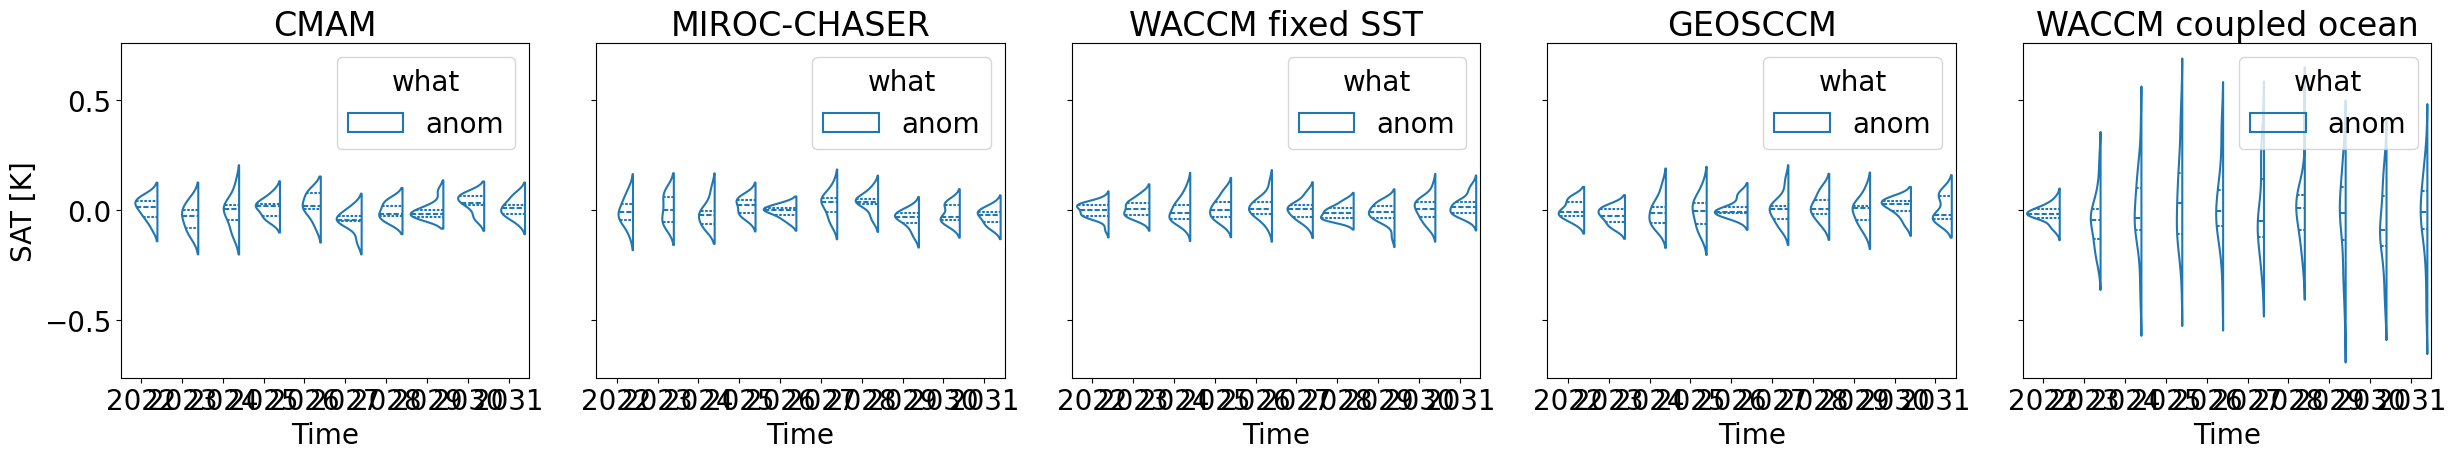

In [21]:
plt.rcParams.update({"font.size": 20})


fig, axs = plt.subplots(1, 5, figsize= (25, 5), constrained_layout = True, sharey = True)
axs = axs.flatten()

for ax, model in zip(axs, dataframes):
    data = dataframes[model]


    sns.violinplot(data=data[data.what == "anom"], x="time", y="sat", hue="what", split=True, inner="quart", ax = ax, fill = False)
    #sns.lineplot(data=data[data.what == "with"], x="time", y="sat", errorbar='sd', ax = ax)
    #sns.lineplot(data=data[data.what == "without"], x="time", y="sat", errorbar='sd', ax = ax)
    ax.set_ylabel('SAT [K]')
    ax.set_title(f"{model}")
    ax.set_xlabel('Time')

# Apply consistent formatting for y-axis tick labels

plt.tight_layout()
plt.show()

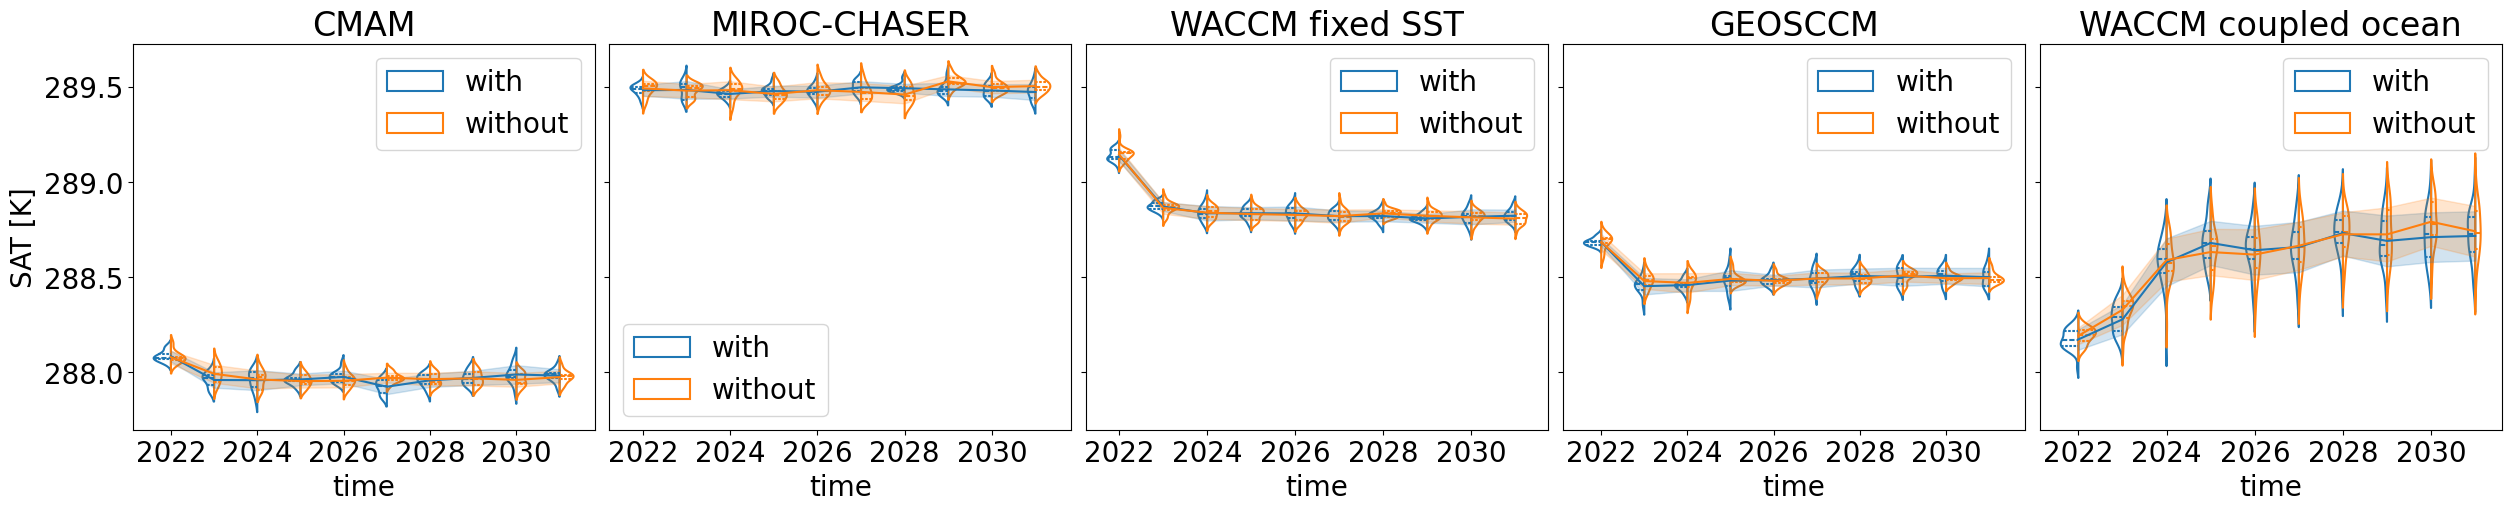

In [22]:
plt.rcParams.update({"font.size": 20})

xticks = df_cmam_all["time"][0:10][::2]
fig, axs = plt.subplots(1, 5, figsize= (25, 5), constrained_layout = True, sharey = True)
axs = axs.flatten()

# define time axis

for ax, model in zip(axs, dataframes):
    data = dataframes[model]


    sns.violinplot(data=data[data.what != "anom"], x="time", y="sat", hue="what", split=True, inner="quart", ax = ax, fill = False)
    sns.lineplot(data=data[data.what == "with"], x="time", y="sat", errorbar='sd', ax = ax)
    sns.lineplot(data=data[data.what == "without"], x="time", y="sat", errorbar='sd', ax = ax)

    ax.set_xticks(xticks)
    ax.set_ylabel('SAT [K]')
    ax.set_title(f"{model}")

plt.savefig(fname = "GMST_annual")
plt.show()
plt.close(fig)

In [23]:
cmam_anom = cmam_w.sat.mean("ens") - cmam_wo.sat.mean("ens")
cmam_anom_f3y = cmam_anom.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")


miroc_anom = miroc_w.sat.mean("ens") - miroc_wo.sat.mean("ens")
miroc_anom_f3y = miroc_anom.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")


waccm_anom = waccm_w.sat.mean("ens") - waccm_wo.sat.mean("ens")
waccm_anom_f3y = waccm_anom.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")


geos_anom = geos_w.sat.mean("ens") - geos_wo.sat.mean("ens")
geos_anom_f3y = geos_anom.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")


waccm2_anom = waccm2_w.sat.mean("ens") - waccm2_wo.sat.mean("ens")
waccm2_anom_f3y = waccm2_anom.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")

In [24]:
cmam_w_f3y = cmam_w.sat.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")
cmam_wo_f3y = cmam_wo.sat.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")

miroc_w_f3y = miroc_w.sat.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")
miroc_wo_f3y = miroc_wo.sat.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")

geos_w_f3y = geos_w.sat.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")
geos_wo_f3y = geos_wo.sat.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")

waccm_w_f3y = waccm_w.sat.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")
waccm_wo_f3y = waccm_wo.sat.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")

waccm2_w_f3y = waccm2_w.sat.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")
waccm2_wo_f3y = waccm2_wo.sat.sel(time = slice("2022", "2024")).groupby("time.season").mean("time")

In [25]:
# Define seasons and prepare the dictionary
datasets = {"CMAM": [cmam_w_f3y, cmam_wo_f3y], "MIROC-CHASER": [miroc_w_f3y, miroc_wo_f3y], "GEOSCCM": [geos_w_f3y, geos_wo_f3y], "WACCM fixed SST": [waccm_w_f3y, waccm_wo_f3y], "WACCM coupled ocean": [waccm2_w_f3y, waccm2_wo_f3y]}
seasons = ["DJF", "MAM", "JJA", "SON"]
pv_data = {}

# Loop over models
for model in datasets.keys():
    pv_data[model] = {}  
    
    # Loop over seasons
    for season in seasons:
        
        # Extract seasonal data for with and without HTHH
        data_w = datasets[model][0].sel(season=season)  
        data_wo = datasets[model][1].sel(season=season)
        
        # t-test equal_var = False bc cmam has 10 ens with and 9 without
        _, p_val = stats.ttest_ind(data_w, data_wo, axis=0, equal_var=False)

        # results in pv_data
        pv_data[model][season] = p_val



/home/brunol/miniconda3/envs/HTHH_Bruno/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:605: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [26]:
vmin = min([cmam_anom_f3y.min(), miroc_anom_f3y.min(), geos_anom_f3y.min(), waccm_anom_f3y.min(), waccm2_anom_f3y.min()]).values
vmax = max([cmam_anom_f3y.min(), miroc_anom_f3y.min(), geos_anom_f3y.min(), waccm_anom_f3y.min(), waccm2_anom_f3y.min()]).values


if abs(vmin) > abs(vmax):
    vmax = abs(vmin)
else:
    vmin = -vmax

divnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

In [27]:
seasonal_data = {"CMAM": cmam_anom_f3y, "MIROC-CHASER": miroc_anom_f3y, "GEOSCCM": geos_anom_f3y, "WACCM fixed SST": waccm_anom_f3y, "WACCM coupled ocean": waccm2_anom_f3y}

python: /croot/libnetcdf_1691154366938/work/libsrc/posixio.c:449: px_rel: Assertion `pxp->bf_offset <= offset && offset < pxp->bf_offset + (off_t) pxp->bf_extent' failed.
python: /croot/libnetcdf_1691154366938/work/libsrc/posixio.c:449: px_rel: Assertion `pxp->bf_offset <= offset && offset < pxp->bf_offset + (off_t) pxp->bf_extent' failed.
python: /croot/libnetcdf_1691154366938/work/libsrc/posixio.c:449: px_rel: Assertion `pxp->bf_offset <= offset && offset < pxp->bf_offset + (off_t) pxp->bf_extent' failed.
python: /croot/libnetcdf_1691154366938/work/libsrc/posixio.c:449: px_rel: Assertion `pxp->bf_offset <= offset && offset < pxp->bf_offset + (off_t) pxp->bf_extent' failed.
python: /croot/libnetcdf_1691154366938/work/libsrc/posixio.c:449: px_rel: Assertion `pxp->bf_offset <= offset && offset < pxp->bf_offset + (off_t) pxp->bf_extent' failed.


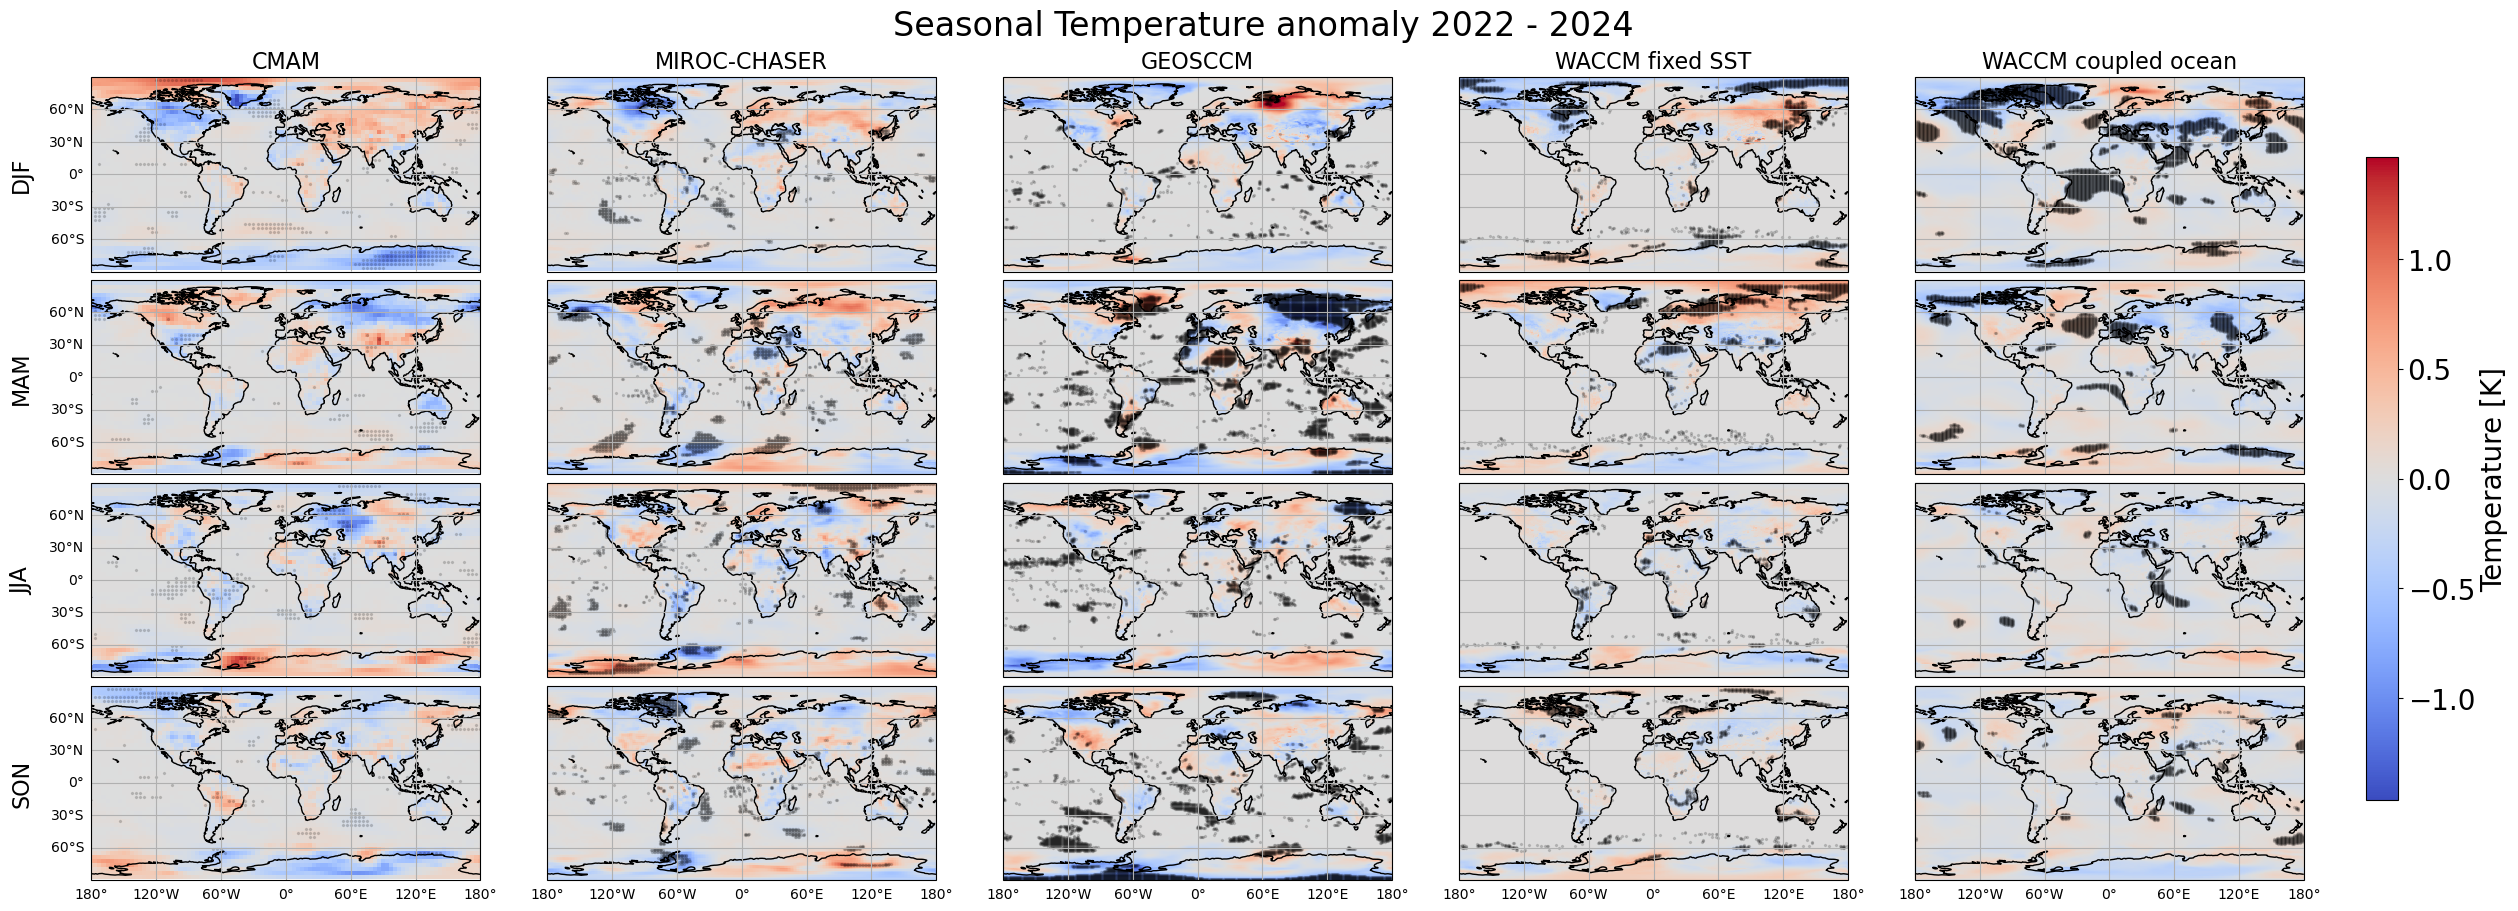

In [28]:
# Define seasons and models
seasons = ["DJF", "MAM", "JJA", "SON"]
models = list(seasonal_data.keys())  # Extract model names from the dictionary

# Set up the figure and subplots
fig, axs = plt.subplots(4, 5, figsize=(25, 9), 
                        subplot_kw={'projection': ccrs.PlateCarree()}, 
                        constrained_layout=True, sharey = True, sharex = True)

# Loop over models (columns) and seasons (rows)
for col, model in enumerate(models):
    for row, season in enumerate(seasons):
        ax = axs[row, col]  # Select subplot

        # Extract the data for the current model and season
        data = seasonal_data[model].sel(season = season)
        sig_lat, sig_lon = np.where(pv_data[model][season] <= 0.05)
        # Plot the data using pcolormesh
        plot = ax.pcolormesh(
            data['lon'], 
            data['lat'], 
            data,
            cmap='coolwarm', 
            norm = divnorm,
            transform=ccrs.PlateCarree()
        )

        ax.scatter(
            data["lon"][sig_lon],
            data["lat"][sig_lat],
            color = "black",
            marker = "x",
            s = 2,
            alpha = 0.2
        )
        # Add coastlines for context
        ax.coastlines()

        # Configure gridlines with smaller font size
        gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False

        # Show latitude labels only for the first column
        if col == 0:
            gl.left_labels = True
            gl.ylabel_style = {"fontsize": 10}  # Smaller font size
        else:
            gl.left_labels = False

        # Show longitude labels only for the bottom row
        if row == len(seasons) - 1:
            gl.bottom_labels = True
            gl.xlabel_style = {"fontsize": 10}  # Smaller font size
        else:
            gl.bottom_labels = False

        # Add model titles for the top row
        if row == 0:
            ax.set_title(model, fontsize=16)

        # Add season label (larger and more to the left)
        if col == 0:
            ax.text(-0.15, 0.5, season, va='center', ha='right', 
                    rotation=90, transform=ax.transAxes, fontsize=16)
            
# Add a single colorbar for the entire figure
cbar = fig.colorbar(plot, ax=axs, orientation='vertical', fraction=0.02, pad=0.02, shrink = 0.8)
cbar.set_label('Temperature [K]')

fig.suptitle("Seasonal Temperature anomaly 2022 - 2024")
plt.savefig("f3y_season_temp_anom")
plt.show()
plt.close(fig)

In [29]:
cmam_anom = cmam_w.sat.mean("ens") - cmam_wo.sat.mean("ens")
cmam_anom_4t6 = cmam_anom.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")


miroc_anom = miroc_w.sat.mean("ens") - miroc_wo.sat.mean("ens")
miroc_anom_4t6 = miroc_anom.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")


waccm_anom = waccm_w.sat.mean("ens") - waccm_wo.sat.mean("ens")
waccm_anom_4t6 = waccm_anom.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")


geos_anom = geos_w.sat.mean("ens") - geos_wo.sat.mean("ens")
geos_anom_4t6 = geos_anom.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")


waccm2_anom = waccm2_w.sat.mean("ens") - waccm2_wo.sat.mean("ens")
waccm2_anom_4t6 = waccm2_anom.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")

In [30]:
cmam_w_4t6 = cmam_w.sat.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")
cmam_wo_4t6 = cmam_wo.sat.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")

miroc_w_4t6 = miroc_w.sat.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")
miroc_wo_4t6 = miroc_wo.sat.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")

geos_w_4t6 = geos_w.sat.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")
geos_wo_4t6 = geos_wo.sat.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")

waccm_w_4t6 = waccm_w.sat.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")
waccm_wo_4t6 = waccm_wo.sat.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")

waccm2_w_4t6 = waccm2_w.sat.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")
waccm2_wo_4t6 = waccm2_wo.sat.sel(time = slice("2025", "2027")).groupby("time.season").mean("time")

# Define seasons and prepare the dictionary
datasets = {"CMAM": [cmam_w_4t6, cmam_wo_4t6], "MIROC-CHASER": [miroc_w_4t6, miroc_wo_4t6], "GEOSCCM": [geos_w_4t6, geos_wo_4t6], "WACCM fixed SST": [waccm_w_4t6, waccm_wo_4t6], "WACCM coupled ocean": [waccm2_w_4t6, waccm2_wo_4t6]}
seasons = ["DJF", "MAM", "JJA", "SON"]
pv_data = {}

# Loop over models
for model in datasets.keys():
    pv_data[model] = {}  
    
    # Loop over seasons
    for season in seasons:
        
        # Extract seasonal data for with and without HTHH
        data_w = datasets[model][0].sel(season=season)  
        data_wo = datasets[model][1].sel(season=season)
        
        # t-test equal_var = False bc cmam has 10 ens with and 9 without
        _, p_val = stats.ttest_ind(data_w, data_wo, axis=0, equal_var=False)

        # results in pv_data
        pv_data[model][season] = p_val

/home/brunol/miniconda3/envs/HTHH_Bruno/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:605: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [31]:
vmin = min([cmam_anom_4t6.min(), miroc_anom_4t6.min(), geos_anom_4t6.min(), waccm_anom_4t6.min(), waccm2_anom_4t6.min()]).values
vmax = max([cmam_anom_4t6.min(), miroc_anom_4t6.min(), geos_anom_4t6.min(), waccm_anom_4t6.min(), waccm2_anom_4t6.min()]).values


if abs(vmin) > abs(vmax):
    vmax = abs(vmin)
else:
    vmin = -vmax

divnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

In [32]:
seasonal_data = {"CMAM": cmam_anom_4t6, "MIROC-CHASER": miroc_anom_4t6, "GEOSCCM": geos_anom_4t6, "WACCM fixed SST": waccm_anom_4t6, "WACCM coupled ocean": waccm2_anom_4t6}

python: /croot/libnetcdf_1691154366938/work/libsrc/posixio.c:449: px_rel: Assertion `pxp->bf_offset <= offset && offset < pxp->bf_offset + (off_t) pxp->bf_extent' failed.
python: /croot/libnetcdf_1691154366938/work/libsrc/posixio.c:449: px_rel: Assertion `pxp->bf_offset <= offset && offset < pxp->bf_offset + (off_t) pxp->bf_extent' failed.
python: /croot/libnetcdf_1691154366938/work/libsrc/posixio.c:449: px_rel: Assertion `pxp->bf_offset <= offset && offset < pxp->bf_offset + (off_t) pxp->bf_extent' failed.
python: /croot/libnetcdf_1691154366938/work/libsrc/posixio.c:449: px_rel: Assertion `pxp->bf_offset <= offset && offset < pxp->bf_offset + (off_t) pxp->bf_extent' failed.


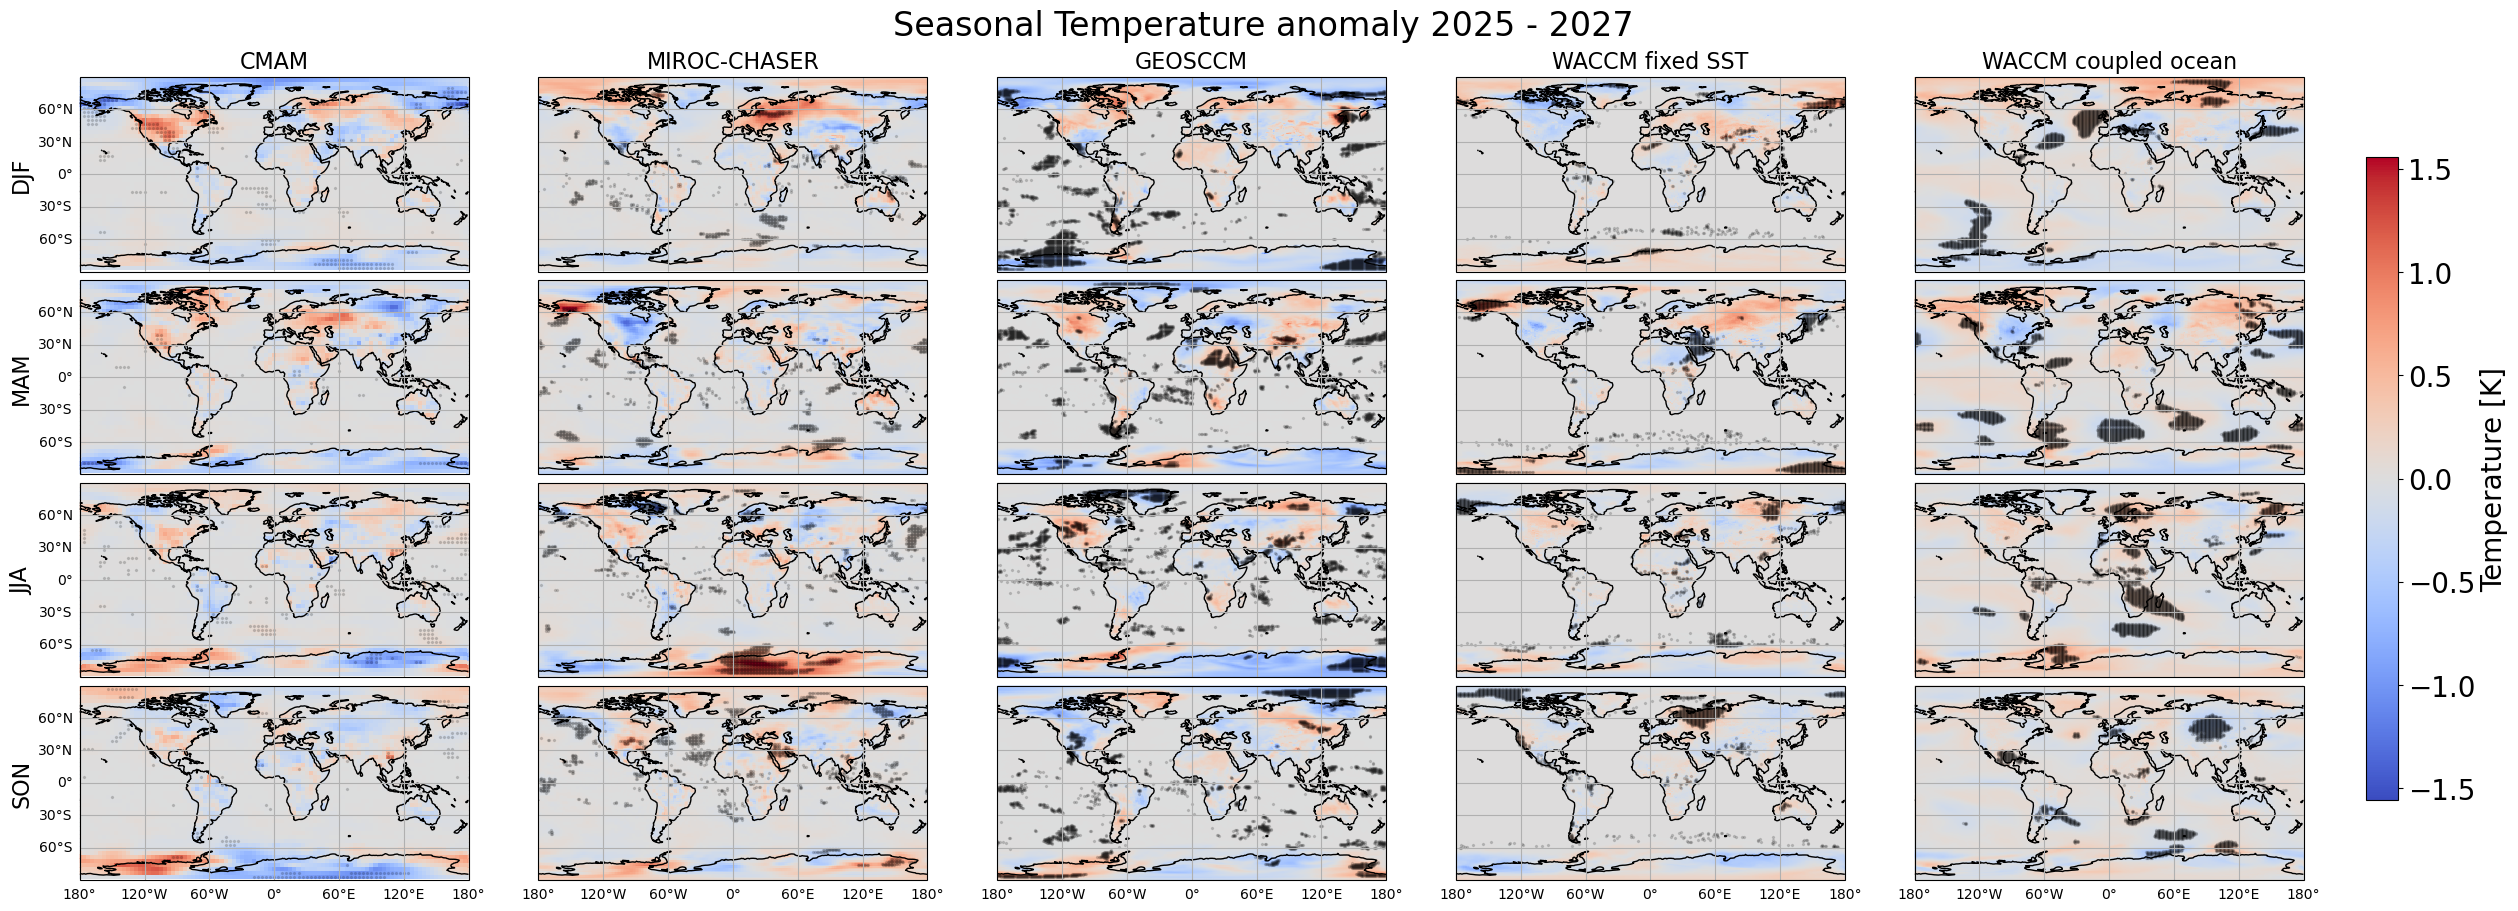

In [33]:
# Define seasons and models
seasons = ["DJF", "MAM", "JJA", "SON"]
models = list(seasonal_data.keys())  # Extract model names from the dictionary

# Set up the figure and subplots
fig, axs = plt.subplots(4, 5, figsize=(25, 9), 
                        subplot_kw={'projection': ccrs.PlateCarree()}, 
                        constrained_layout=True, sharey = True, sharex = True)

# Loop over models (columns) and seasons (rows)
for col, model in enumerate(models):
    for row, season in enumerate(seasons):
        ax = axs[row, col]  # Select subplot

        # Extract the data for the current model and season
        data = seasonal_data[model].sel(season = season)
        sig_lat, sig_lon = np.where(pv_data[model][season] <= 0.05)
        # Plot the data using pcolormesh
        plot = ax.pcolormesh(
            data['lon'], 
            data['lat'], 
            data,
            cmap='coolwarm', 
            norm = divnorm,
            transform=ccrs.PlateCarree()
        )

        ax.scatter(
            data["lon"][sig_lon],
            data["lat"][sig_lat],
            color = "black",
            marker = "x",
            s = 2,
            alpha = 0.2
        )
        # Add coastlines for context
        ax.coastlines()

        # Configure gridlines with smaller font size
        gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False

        # Show latitude labels only for the first column
        if col == 0:
            gl.left_labels = True
            gl.ylabel_style = {"fontsize": 10}  # Smaller font size
        else:
            gl.left_labels = False

        # Show longitude labels only for the bottom row
        if row == len(seasons) - 1:
            gl.bottom_labels = True
            gl.xlabel_style = {"fontsize": 10}  # Smaller font size
        else:
            gl.bottom_labels = False

        # Add model titles for the top row
        if row == 0:
            ax.set_title(model, fontsize=16)

        # Add season label (larger and more to the left)
        if col == 0:
            ax.text(-0.12, 0.5, season, va='center', ha='right', 
                    rotation=90, transform=ax.transAxes, fontsize=16)
            
# Add a single colorbar for the entire figure
cbar = fig.colorbar(plot, ax=axs, orientation='vertical', fraction=0.02, pad=0.02, shrink = 0.8)
cbar.set_label('Temperature [K]')

fig.suptitle("Seasonal Temperature anomaly 2025 - 2027")
plt.savefig("4t6_season_temp_anom")
plt.show()
plt.close(fig)

In [34]:
cmam_anom = cmam_w.sat.mean("ens") - cmam_wo.sat.mean("ens")
cmam_anom_sel = cmam_anom.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")


miroc_anom = miroc_w.sat.mean("ens") - miroc_wo.sat.mean("ens")
miroc_anom_sel = miroc_anom.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")


waccm_anom = waccm_w.sat.mean("ens") - waccm_wo.sat.mean("ens")
waccm_anom_sel = waccm_anom.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")


geos_anom = geos_w.sat.mean("ens") - geos_wo.sat.mean("ens")
geos_anom_sel = geos_anom.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")


waccm2_anom = waccm2_w.sat.mean("ens") - waccm2_wo.sat.mean("ens")
waccm2_anom_sel = waccm2_anom.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")

In [35]:
seasonal_data = {"CMAM": cmam_anom_sel, "MIROC-CHASER": miroc_anom_sel, "GEOSCCM": geos_anom_sel, "WACCM fixed SST": waccm_anom_sel, "WACCM coupled ocean": waccm2_anom_sel}

In [36]:
cmam_w_sel = cmam_w.sat.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")
cmam_wo_sel = cmam_wo.sat.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")

miroc_w_sel = miroc_w.sat.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")
miroc_wo_sel = miroc_wo.sat.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")

geos_w_sel = geos_w.sat.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")
geos_wo_sel = geos_wo.sat.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")

waccm_w_sel = waccm_w.sat.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")
waccm_wo_sel = waccm_wo.sat.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")

waccm2_w_sel = waccm2_w.sat.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")
waccm2_wo_sel = waccm2_wo.sat.sel(time = slice("2028", "2031")).groupby("time.season").mean("time")

# Define seasons and prepare the dictionary
datasets = {"CMAM": [cmam_w_sel, cmam_wo_sel], "MIROC-CHASER": [miroc_w_sel, miroc_wo_sel], "GEOSCCM": [geos_w_sel, geos_wo_sel], "WACCM fixed SST": [waccm_w_sel, waccm_wo_sel], "WACCM coupled ocean": [waccm2_w_sel, waccm2_wo_sel]}
seasons = ["DJF", "MAM", "JJA", "SON"]
pv_data = {}

# Loop over models
for model in datasets.keys():
    pv_data[model] = {}  
    
    # Loop over seasons
    for season in seasons:
        
        # Extract seasonal data for with and without HTHH
        data_w = datasets[model][0].sel(season=season)  
        data_wo = datasets[model][1].sel(season=season)
        
        # t-test equal_var = False bc cmam has 10 ens with and 9 without
        _, p_val = stats.ttest_ind(data_w, data_wo, axis=0, equal_var=False)

        # results in pv_data
        pv_data[model][season] = p_val

/home/brunol/miniconda3/envs/HTHH_Bruno/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:605: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [37]:
vmin = min([cmam_anom_sel.min(), miroc_anom_sel.min(), waccm_anom_sel.min(), geos_anom_sel.min(), waccm2_anom_sel.min()]).values
vmax = max([cmam_anom_sel.min(), miroc_anom_sel.min(), waccm_anom_sel.min(), geos_anom_sel.min(), waccm2_anom_sel.min()]).values


if abs(vmin) > abs(vmax):
    vmax = abs(vmin)
else:
    vmin = -vmax

divnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

python: /croot/libnetcdf_1691154366938/work/libsrc/posixio.c:449: px_rel: Assertion `pxp->bf_offset <= offset && offset < pxp->bf_offset + (off_t) pxp->bf_extent' failed.


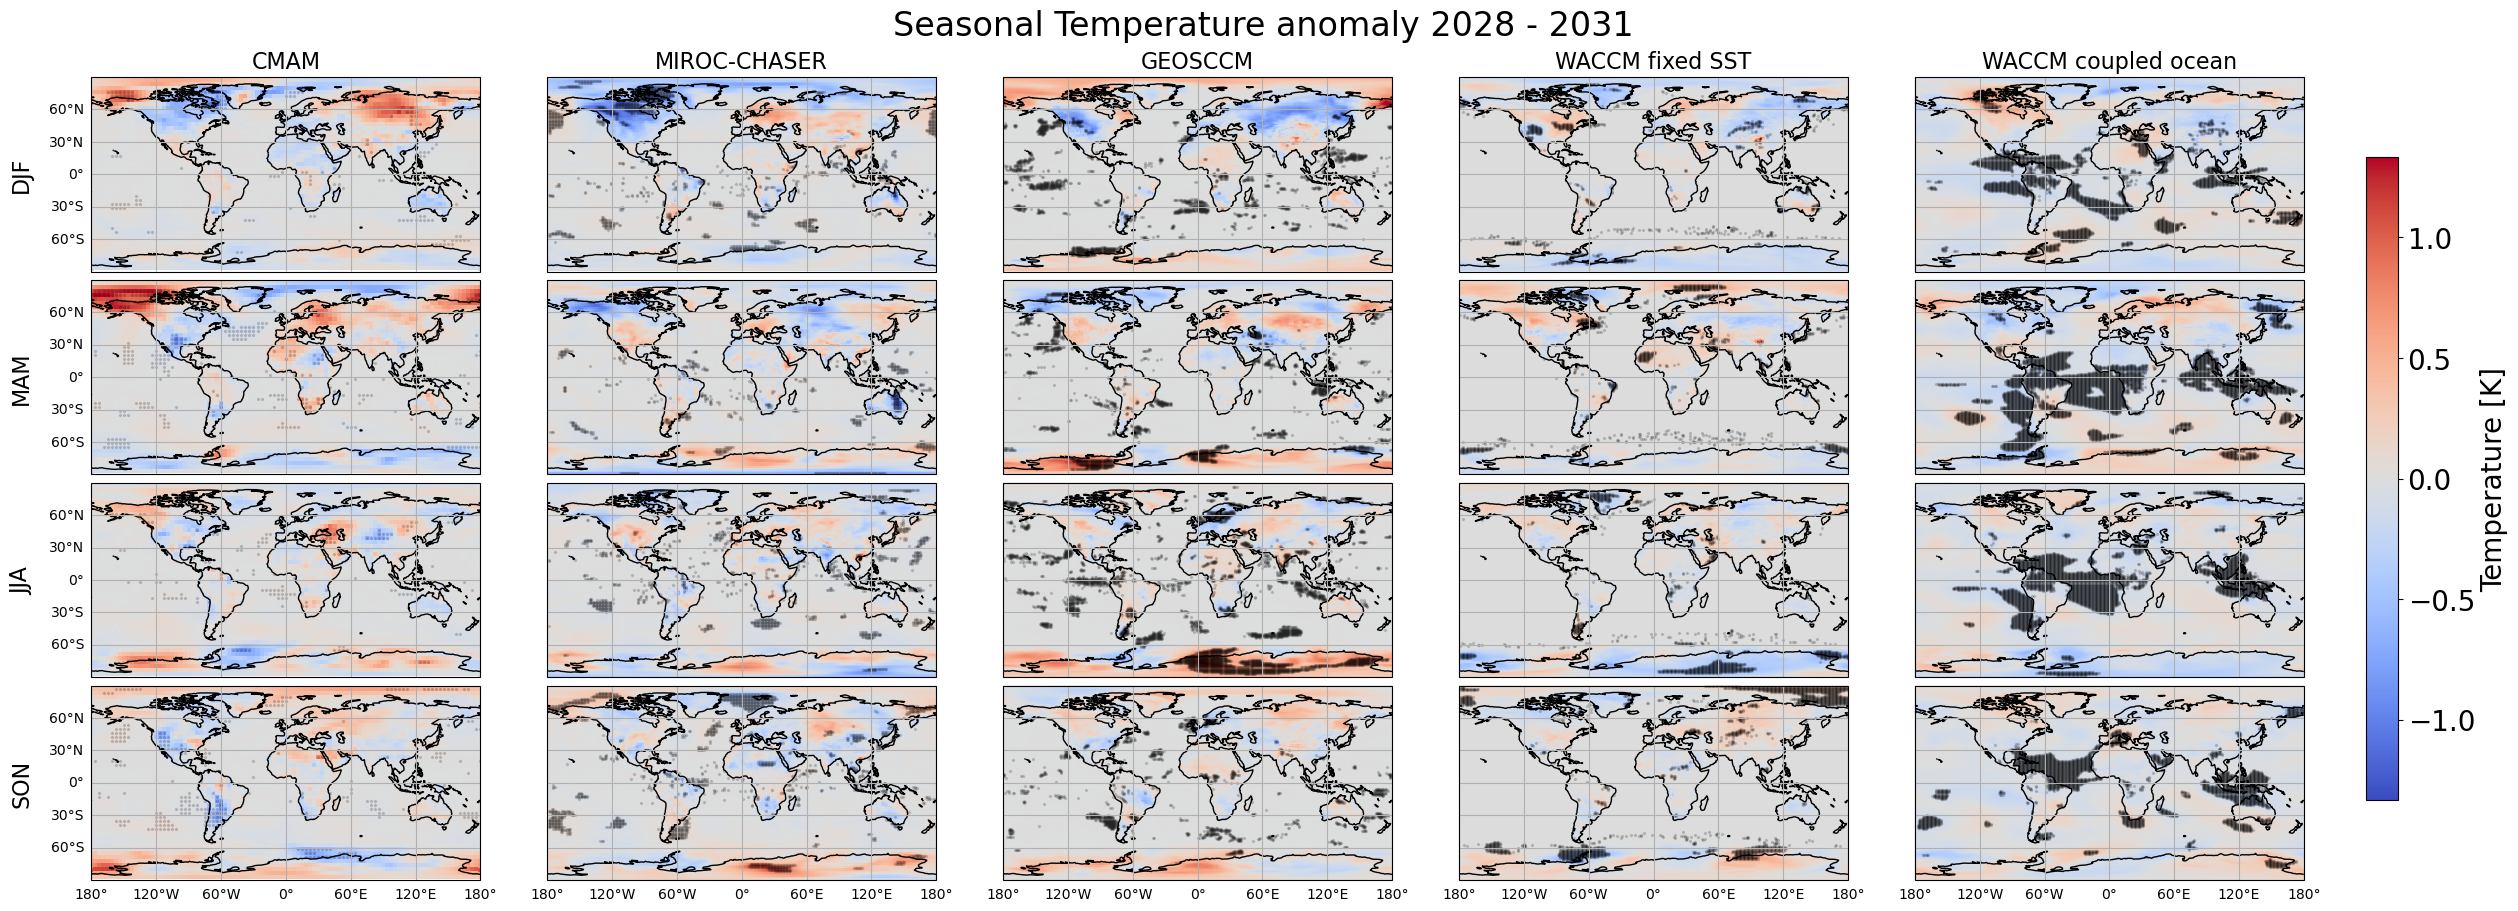

In [38]:
# Define seasons and models
seasons = ["DJF", "MAM", "JJA", "SON"]
models = list(seasonal_data.keys())  # Extract model names from the dictionary

# Set up the figure and subplots
fig, axs = plt.subplots(4, 5, figsize=(25, 9), 
                        subplot_kw={'projection': ccrs.PlateCarree()}, 
                        constrained_layout=True, sharey = True, sharex = True)

# Loop over models (columns) and seasons (rows)
for col, model in enumerate(models):
    for row, season in enumerate(seasons):
        ax = axs[row, col]  # Select subplot

        # Extract the data for the current model and season
        data = seasonal_data[model].sel(season = season)
        sig_lat, sig_lon = np.where(pv_data[model][season] <= 0.05)
        # Plot the data using pcolormesh
        plot = ax.pcolormesh(
            data['lon'], 
            data['lat'], 
            data,
            cmap='coolwarm', 
            norm = divnorm,
            transform=ccrs.PlateCarree()
        )

        ax.scatter(
            data["lon"][sig_lon],
            data["lat"][sig_lat],
            color = "black",
            marker = "x",
            s = 2,
            alpha = 0.2
        )
        # Add coastlines for context
        ax.coastlines()

        # gridlines
        gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False

        # latitude labels only first column
        if col == 0:
            gl.left_labels = True
            gl.ylabel_style = {"fontsize": 10}  # Smaller font size
        else:
            gl.left_labels = False

        # longitude labels only bottom row
        if row == len(seasons) - 1:
            gl.bottom_labels = True
            gl.xlabel_style = {"fontsize": 10}  # Smaller font size
        else:
            gl.bottom_labels = False

        # Add model titles for the top row
        if row == 0:
            ax.set_title(model, fontsize=16)

        # Add season label
        if col == 0:
            ax.text(-0.15, 0.5, season, va='center', ha='right', 
                    rotation=90, transform=ax.transAxes, fontsize=16)
            
# Add a single colorbar for the entire figure
cbar = fig.colorbar(plot, ax=axs, orientation='vertical', fraction=0.02, pad=0.02, shrink = 0.8)
cbar.set_label('Temperature [K]')

fig.suptitle("Seasonal Temperature anomaly 2028 - 2031")
plt.savefig("rest_season_temp_anom")
plt.show()
plt.close(fig)

In [39]:
cmam_w_season_zm = cmam_w.mean("lon").resample(time = "QS-DEC").mean().sel(time = slice("2022", "2031"))
cmam_wo_season_zm = cmam_wo.mean("lon").resample(time = "QS-DEC").mean().sel(time = slice("2022", "2031"))
cmam_anom_season_zm = cmam_w_season_zm.mean("ens") - cmam_wo_season_zm.mean("ens")

miroc_w_season_zm = miroc_w.mean("lon").resample(time = "QS-DEC").mean().sel(time = slice("2022", "2031"))
miroc_wo_season_zm = miroc_wo.mean("lon").resample(time = "QS-DEC").mean().sel(time = slice("2022", "2031"))
miroc_anom_season_zm = miroc_w_season_zm.mean("ens") - miroc_wo_season_zm.mean("ens")

waccm_w_season_zm = waccm_w.mean("lon").resample(time = "QS-DEC").mean().sel(time = slice("2022", "2031"))
waccm_wo_season_zm = waccm_wo.mean("lon").resample(time = "QS-DEC").mean().sel(time = slice("2022", "2031"))
waccm_anom_season_zm = waccm_w_season_zm.mean("ens") - waccm_wo_season_zm.mean("ens")

waccm2_w_season_zm = waccm2_w.mean("lon").resample(time = "QS-DEC").mean().sel(time = slice("2022", "2031"))
waccm2_wo_season_zm = waccm2_wo.mean("lon").resample(time = "QS-DEC").mean().sel(time = slice("2022", "2031"))
waccm2_anom_season_zm = waccm2_w_season_zm.mean("ens") - waccm2_wo_season_zm.mean("ens")

geos_w_season_zm = geos_w.mean("lon").resample(time = "QS-DEC").mean().sel(time = slice("2022", "2031"))
geos_wo_season_zm = geos_wo.mean("lon").resample(time = "QS-DEC").mean().sel(time = slice("2022", "2031"))
geos_anom_season_zm = geos_w_season_zm.mean("ens") - geos_wo_season_zm.mean("ens")



In [40]:
# using equal_var = False because there are only 9 ens without pert and 10 with pert
_, cmam_pv = stats.ttest_ind(cmam_w_season_zm.sat.values, cmam_wo_season_zm.sat.values, axis = 1, equal_var = False)

_, miroc_pv = stats.ttest_ind(miroc_w_season_zm.sat.values, miroc_wo_season_zm.sat.values, axis = 1, equal_var = False)

_, waccm_pv = stats.ttest_ind(waccm_w_season_zm.sat.values, waccm_wo_season_zm.sat.values, axis = 1, equal_var = False)

_, waccm2_pv = stats.ttest_ind(waccm2_w_season_zm.sat.values, waccm2_wo_season_zm.sat.values, axis = 1, equal_var = False)

_, geos_pv = stats.ttest_ind(geos_w_season_zm.sat.values, geos_wo_season_zm.sat.values, axis = 1, equal_var = False)

/home/brunol/miniconda3/envs/HTHH_Bruno/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:605: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [41]:
vmin = min([miroc_anom_season_zm.sat.min(), cmam_anom_season_zm.sat.min(), geos_anom_season_zm.sat.min(), waccm_anom_season_zm.sat.min(), waccm2_anom_season_zm.sat.min()]).values
vmax = max([miroc_anom_season_zm.sat.max(), cmam_anom_season_zm.sat.max(), geos_anom_season_zm.sat.max(), waccm_anom_season_zm.sat.max(), waccm2_anom_season_zm.sat.max()]).values


if abs(vmin) > abs(vmax):
    vmax = abs(vmin)
else:
    vmin = -vmax



In [42]:
divnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

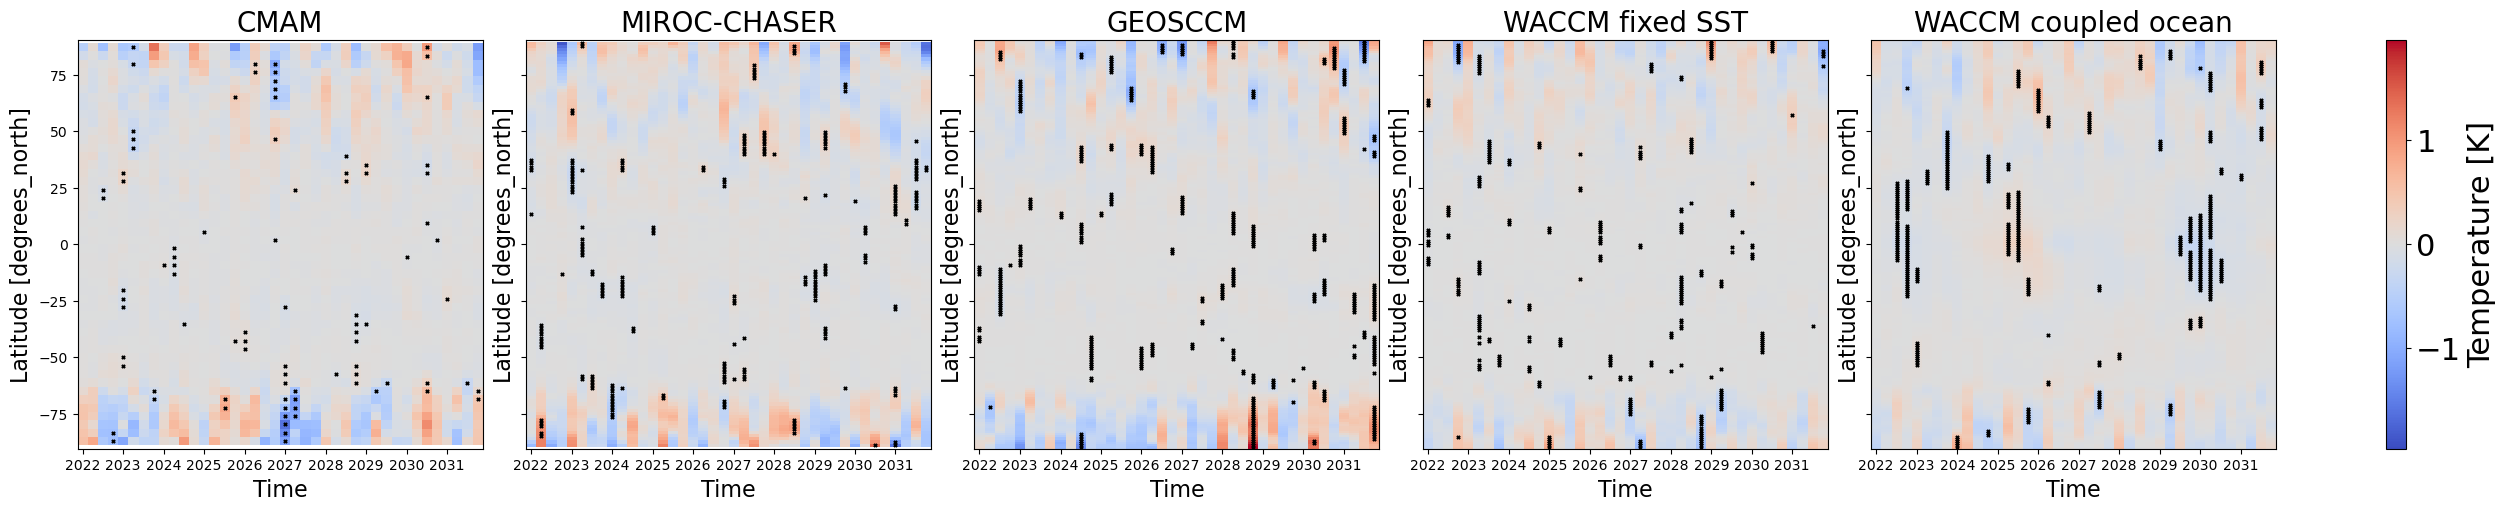

In [43]:
plt.rcParams.update({"font.size": 22})
xticks = list(cmam_anom_season_zm["time"].values)[::4]

# Create the pcolormesh plot
fig, axs = plt.subplots(1, 5, figsize=(25, 5), constrained_layout = True, sharey = True, sharex = True)
axs = axs.flatten()


titles = ["CMAM", "MIROC-CHASER", "GEOSCCM", "WACCM fixed SST", "WACCM coupled ocean"]
datasets = [cmam_anom_season_zm, miroc_anom_season_zm, geos_anom_season_zm, waccm_anom_season_zm, waccm2_anom_season_zm]
pv_das = [cmam_pv, miroc_pv, geos_pv, waccm_pv, waccm2_pv]

for i, (data, pv_data, ax, title) in enumerate(zip(datasets, pv_das, axs, titles)):
    sig_time, sig_lat = np.where(pv_data <= 0.05)
    
    mesh = ax.pcolormesh(
    data["time"], 
        data["lat"], 
        data.sat.T, 
        shading="auto", 
        cmap="coolwarm",
        norm = divnorm
        
    )

    # Add the scatterplot for significant values
    ax.scatter(
        data["time"][sig_time],
        data["lat"][sig_lat],
        color="black",
        marker="x",
        s = 5
    )

    # Add labels, title, and legend
    ax.set_xlabel("Time", fontsize=16)
    ax.set_ylabel("Latitude [degrees_north]", fontsize=16)
    ax.set_title(title, fontsize=20)
    ax.tick_params(axis='both', labelsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xticks(xticks)               

# Add a colorbar
fig.colorbar(mesh, ax=axs, orientation="vertical", fraction=0.05, pad=0.05, label="Temperature [K]")

# Show the plot
plt.savefig(fname = "seasonal_temp_zm")
plt.show()
plt.close(fig)